In [1]:
import sys
sys.path.append("..")
from lib.kalman_gst import *  
from pygsti.modelpacks import smq1Q_XY as std

In [2]:
def filter_dataset(prior_model, prior_covar, dataset, circ_list, 
                   Q_add, R_add, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=False, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False):
    param_history = []
    covar_history = []
    prior_innovs = []
    post_innovs = []
    kgains = []
    
    ekf = ExtendedKalmanFilter(prior_model.copy(), prior_covar)
    if save_params_and_covars:
        param_history.append(prior_model.to_vector())
        covar_history.append(prior_covar)
    for circ in tqdm(circ_list):
        counts = dataset[circ].counts
        cvec = vector_from_outcomes(counts, 2**circ.width)
        innov, kgain = ekf.update(circ, cvec, clip_range=clip_range, Q=Q_add, R_additional=R_add, max_itr=max_itr, itr_eps=itr_eps)
        if save_prior_innovations:
            prior_innovs.append(innov)
        if save_kgains:
            kgains.append(kgain)
        if save_posterior_innovations:
            post_predict = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
            post_innov = cvec/sum(cvec) - post_predict
            post_innovs.append(post_innov)
        if save_params_and_covars:
            param_history.append(ekf.model.to_vector())
            covar_history.append(ekf.P)
    return ekf.model, ekf.P, (param_history, covar_history, prior_innovs, post_innovs, kgains)

In [19]:
NUM_SHOTS = 256
SEED = 2022

In [20]:
# setup the datagen model
max_fogi_error_rate = 0.01
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
target_model = mdl_datagen.copy()
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [30]:
prior_covar = max_fogi_error_rate**2*np.eye(target_model.num_params)
uniform_prior_model = target_model.copy()
uniform_prior_model.from_vector(np.random.uniform(0, 1, target_model.num_params))

In [32]:
# check that the datagen model is CPTP and print metrics w.r.t. the target model
print('Model is CPTP... ', model_is_cptp(mdl_datagen))
print('avg. gate-set infidelity: ', avg_gs_infidelity(mdl_datagen, target_model))
print('mean square error: ', mserror(mdl_datagen, target_model))


Model is CPTP...  True
avg. gate-set infidelity:  0.01134240281120219
mean square error:  0.0003820126385570067


In [34]:
# make an edesign and simulate the data
maxLengths = [1,2,4, 8]
edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, edesign, NUM_SHOTS, seed=SEED) #, sample_error='none')

In [35]:
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  56 circuits ---
Iterative GST Total Time: 3.6s


--- Iterative GST: [##################################################] 100.0%  96 circuits ---
Iterative GST Total Time: 2.2s
--- Iterative GST: [##################################################] 100.0%  177 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  304 circuits ---
Iterative GST Total Time: 1.4s


In [36]:
germ_length_ranges = {
    0: [0, 92], 
    1: [92, 168], 
    2: [168, 285], 
    3: [285, 448],
    4: [448, 616]
}

germ_length_ranges = {
    0: [0, 56], 
    1: [56, 96], 
    2: [96, 177], 
    3: [177, 304]
}

In [37]:
# run a Kalman filter in the usual way
usual_post_model, usual_post_covar, saved_data = filter_dataset(target_model, prior_covar, dataset, edesign.circuit_lists[-1], 
    None, None, clip_range=[-1, 1],
    max_itr=1, itr_eps=1e-4,
    save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████| 304/304 [00:15<00:00, 19.07it/s]


In [38]:
usual_parameter_history = saved_data[0]
usual_covar_history = saved_data[1]

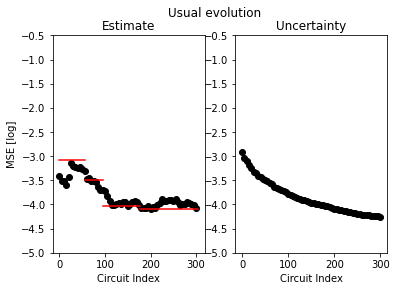

In [39]:
%matplotlib inline
plt_spacing = 5
yrange = [-5, -0.5]
make_error_plot('Usual evolution', usual_parameter_history, mdl_datagen.to_vector(), usual_covar_history, yrange, mle_estimates, germ_length_ranges, plt_spacing)

# Mutual information score

If we assume that the innovations and the state are jointly Gaussian distributed, then a metric for the code performance is
$$
    \log \frac{|\Sigma_X| |\Sigma_Y|}{|\Sigma|} = \log \frac{|\Sigma_X|}{|\Sigma_X - \Sigma_{XY} \Sigma_Y^{-1} \Sigma_YK|} 
$$
$$
    = \sum_i \log \lambda_i^{\text{prior}} - \log \lambda_i^{\text{post}}
$$
In practice, we'll want to cutoff eigenvalues that are below a threshold

For the Kalman filter, we have that 
$$
    \Sigma_X - \Sigma_{XY} \Sigma_Y^{-1} \Sigma_{YX} = P - P H^T ( H P H^T + R )^{-1} H P
$$
if we want to include non-linear error, then we'll calculate the covariance of the nonlinear error
$$
    U = \sum w^C_i ( u_i - \bar{u}_i )( u_i - \bar{u}_i )^T
$$
where 
$$
    u_i = h_k(x^{(i)}) - h_k (\hat{x}_{\text{prior}}) - H_k (\hat{x}_{\text{prior}} - x^{(i)})
$$
and 
$$
    \bar{u} = \sum w^M_i u_i
$$

then, we'll add this covariance to the S-matrix so that the score is 
$$
     \log \frac{|P|}{|P - P H^T ( H P H^T + R  + U)^{-1} H P|} 
$$


In [40]:
from filterpy.kalman import MerweScaledSigmaPoints

In [57]:
def update_covar(prior_covar, jac, R):
    S_k = jac@prior_covar@jac.T + R
    K_k = prior_covar@jac.T@np.linalg.pinv(S_k)
    return prior_covar - K_k@jac@prior_covar

def average_nonlinear_error_covar(circ, model, jac, model_covar):
    xmean = model.to_vector()
    merwe_points= MerweScaledSigmaPoints(model.num_params, alpha=.1, beta=2., kappa=-1)
    sigma_points = merwe_points.sigma_points(model.to_vector(), model_covar)
    mean_weights = merwe_points.Wm
    covar_weights = merwe_points.Wc
    
    predict_0 = vector_from_outcomes(model.probabilities(circ), 2**circ.width)
    
    # calculate mean error 
    nonlin_errors = []
    for idx, point in enumerate(sigma_points):
        model.from_vector(point)
        predict_sigppoint = vector_from_outcomes(model.probabilities(circ), 2**circ.width)
        linearized_prediction = predict_0 + jac@(xmean - point)
        error = predict_sigppoint - linearized_prediction
        nonlin_errors.append(error)
    mean_error = sum([mean_weights[i]*nonlin_errors[i] for i in range(len(sigma_points))])
    
    # calculate covar error 
    outer_products = []
    for idx, e in enumerate(nonlin_errors):
        shifted_error = e - mean_error
        outer_products.append( np.outer(shifted_error, shifted_error) )
    covar_error = sum([covar_weights[i]*outer_products[i] for i in range(len(sigma_points))])
    return covar_error

def calculate_posterior_covar_list(prior_covar, circ_list, model, num_samples, include_nonlin_covar=True, Q=None):
    post_covars = dict()
    if Q is None:
        Q = np.zeros(prior_covar.shape)
    
    P = prior_covar + Q
    for circ in circ_list:
        p_k = vector_from_outcomes(model.probabilities(circ), 2**circ.width)
        jac = matrix_from_jacob(model.sim.dprobs(circ), 2**circ.width)
        R_k = dirichlet_covar(num_samples*p_k)
        if include_nonlin_covar:
            nonlin_covar = average_nonlinear_error_covar(circ, model, jac, prior_covar)
        else:
            nonlin_covar = np.zeros(R_k.shape)
        S_k = jac@P@jac.T + R_k + nonlin_covar
        K_k = prior_covar@jac.T@np.linalg.pinv(S_k)
        post_k = prior_covar - K_k@jac@prior_covar
        post_covars[circ] = post_k
    return post_covars

def score_covars(prior_covar, post_covar, eig_cutoff=1e-12):
    prior_eigs = np.linalg.eigvals(prior_covar)
    post_eigs = np.linalg.eigvals(post_covar)
    prior_clipped_log_det = sum([np.log(e) for e in prior_eigs if e > eig_cutoff])
    post_clipped_log_det = sum([np.log(e) for e in post_eigs if e > eig_cutoff])
    return prior_clipped_log_det - post_clipped_log_det

def score_circuit_list(prior_covar, circ_list, model, num_samples, include_nonlin_covar=True, Q=None, eig_cutoff=1e-20):
    scores = dict()
    post_covars = calculate_posterior_covar_list(prior_covar, circ_list, model, num_samples, include_nonlin_covar, Q)
    for circ in circ_list:
        scores[circ] = score_covars(prior_covar, post_covars[circ], eig_cutoff)
    return scores

In [58]:
from filterpy.kalman import MerweScaledSigmaPoints, UnscentedKalmanFilter

In [59]:
# trasnition and measurement function 
def fx(x, dt):
    return x

filter_model = target_model.copy()

def hx(xvec, **hxargs):
    circ = hxargs['circ']
    hilbert_dims = 2**circ.width
    filter_model.from_vector(xvec)
    probs = filter_model.probabilities(circ)
    pvec = vector_from_outcomes(probs, hilbert_dims)
    return pvec

In [66]:
class AdapativeFilter():
    def __init__(self, initial_model, initial_covar, hdims):
        self.model = initial_model.copy()
        self.x = initial_model.to_vector()
        self.P = initial_covar
        self.mdl_datagen = mdl_datagen
        self.param_history = [self.x]
        self.covar_history = [self.P]
        self.best_circuit_list = []
        self.include_nonlinear_error = False
        points = MerweScaledSigmaPoints(self.model.num_params, alpha=.1, beta=2., kappa=-1)
        self.ukf = UnscentedKalmanFilter(dim_x=self.model.num_params, dim_z=hdims, dt=1, hx=hx, fx=fx, points=points)
        self.ukf.Q = 1e-6*np.eye(self.model.num_params)
        self.ukf.P = initial_covar
        self.ukf.x = self.x
    
    def best_update(self, circ_list, datagen_model, num_samples, eig_cutoff):
        # find the best circuit 
        prior_covar = self.P
        x_prior = self.x
        self.model.from_vector(x_prior)
        model = self.model
        
        Q = 0*np.eye(target_model.num_params)
        
        scores = score_circuit_list(prior_covar, circ_list, model, num_samples, include_nonlin_covar=self.include_nonlinear_error, Q=Q, eig_cutoff=eig_cutoff)
        best_circ = max(scores, key=scores.get)
        self.best_circuit_list.append(best_circ)
        
        # observe the circuit then do a kalman update with the best circuit
        circ = best_circ
        ds = pygsti.data.simulate_data(datagen_model, [circ], num_samples=num_samples)
        counts = vector_from_outcomes(ds[best_circ].counts, 2**circ.width)
        y_k = counts/sum(counts)
        
        probs = model.probabilities(circ)
        p_model = vector_from_outcomes(probs, 2**circ.width)
        
        jacob = matrix_from_jacob(model.sim.dprobs(circ), 2**circ.width)
        mean_frequency = ( counts+np.ones(len(counts)) )/( sum(counts)+len(counts) )
        R = (1/(sum(counts)+len(counts)+1))*categorical_covar(mean_frequency)

        # Kalman gain
        kgain = prior_covar@jacob.T@np.linalg.pinv(jacob@prior_covar@jacob.T + R, 1e-15)

        # Kalman update
        innovation = y_k - p_model
        self.x = x_prior + kgain@innovation
        self.P = (np.eye(model.num_params) - kgain@jacob)@prior_covar
        
        self.param_history.append(self.x )
        self.covar_history.append(self.P)
        
    def best_sigpoint_update(self, circ_list, datagen_model, num_samples, eig_cutoff):
        # find the best circuit 
        prior_covar = self.P
        x_prior = self.x
        self.model.from_vector(x_prior)
        model = self.model
        
        Q = 0*np.eye(target_model.num_params)
        
        scores = score_circuit_list(prior_covar, circ_list, model, num_samples, include_nonlin_covar=self.include_nonlinear_error, Q=Q, eig_cutoff=eig_cutoff)
        best_circ = max(scores, key=scores.get)
        self.best_circuit_list.append(best_circ)
        
        # observe the circuit then do a kalman update with the best circuit
        circ = best_circ
        ds = pygsti.data.simulate_data(datagen_model, [circ], num_samples=num_samples)
        counts = vector_from_outcomes(ds[circ].counts, 2**circ.width)
        y_k = counts/sum(counts)
        R = dirichlet_covar(counts)
        
        # sigma point update
        self.ukf.predict()
        self.ukf.update(y_k, R=R, hx=hx, circ=circ)
        
        self.x = self.ukf.x
        self.P = self.ukf.P
        
        self.param_history.append(self.x)
        self.covar_history.append(self.P)

# Considering all germ 1 circuits

In [92]:
prior_covar = max_fogi_error_rate**2*np.eye(target_model.num_params)

akf = AdapativeFilter(target_model, prior_covar, 2)
num_updates = 56
for n in tqdm(range(num_updates)):
    akf.best_update(edesign.circuit_lists[0], mdl_datagen, num_samples=256, eig_cutoff=1e-10)

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [01:50<00:00,  1.97s/it]


Text(0, 0.5, 'MSE [log]')

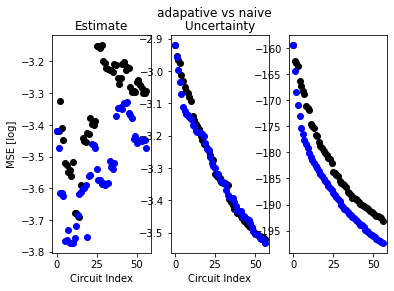

In [93]:
fig, axs = plt.subplots(1, 3)

fig.suptitle('adapative vs naive')
true_params = mdl_datagen.to_vector()

axs[0].set_title('Estimate')
axs[1].set_title('Uncertainty')
plt_spacing = 1

for i in range(0, len(akf.param_history), plt_spacing):
    params = usual_parameter_history[i]
    error = np.log10((params-true_params)@(params-true_params))
    axs[0].scatter(i, error, c='black')
    axs[1].scatter(i, np.log10((np.trace(usual_covar_history[i]))), c='black')
    eff_det = sum([np.log2(e) for e in np.linalg.eigvals(usual_covar_history[i]) if e > 1e-12])
    axs[2].scatter(i, eff_det, c='black')
    
for i in range(0, len(akf.param_history), plt_spacing):
    params = akf.param_history[i]
    error = np.log10((params-true_params)@(params-true_params))
    axs[0].scatter(i, error, c='blue')
    eff_det = sum([np.log2(e) for e in np.linalg.eigvals(akf.covar_history[i]) if e > 1e-12])
    axs[1].scatter(i, np.log10((np.trace(akf.covar_history[i]))), c='blue')
    axs[2].scatter(i, eff_det, c='blue')

axs[0].set_xlabel('Circuit Index')
axs[1].set_xlabel('Circuit Index')
axs[0].set_ylabel('MSE [log]')

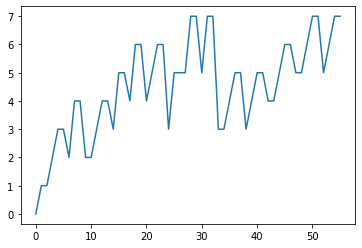

In [94]:
plt.plot([c.depth for c in edesign.circuit_lists[0][0:56]])

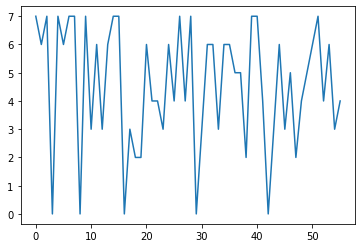

In [95]:
plt.plot([c.depth for c in akf.best_circuit_list])

## adding on germ 2 sequences

In [96]:
prior_covar = max_fogi_error_rate**2*np.eye(target_model.num_params)
num_updates = 96-56
for n in tqdm(range(num_updates)):
    akf.best_update(edesign.circuit_lists[1], mdl_datagen, num_samples=256, eig_cutoff=1e-10)

100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [02:28<00:00,  3.71s/it]


Text(0, 0.5, 'MSE [log]')

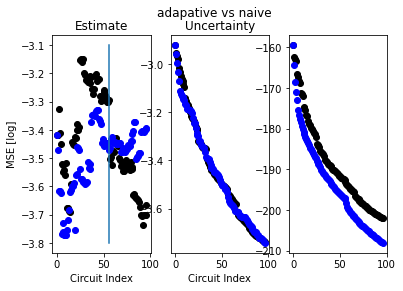

In [99]:
fig, axs = plt.subplots(1, 3)

fig.suptitle('adapative vs naive')
true_params = mdl_datagen.to_vector()

axs[0].set_title('Estimate')
axs[1].set_title('Uncertainty')
plt_spacing = 1

for i in range(0, len(akf.param_history), plt_spacing):
    params = usual_parameter_history[i]
    error = np.log10((params-true_params)@(params-true_params))
    axs[0].scatter(i, error, c='black')
    axs[1].scatter(i, np.log10((np.trace(usual_covar_history[i]))), c='black')
    eff_det = sum([np.log2(e) for e in np.linalg.eigvals(usual_covar_history[i]) if e > 1e-12])
    axs[2].scatter(i, eff_det, c='black')
    
for i in range(0, len(akf.param_history), plt_spacing):
    params = akf.param_history[i]
    error = np.log10((params-true_params)@(params-true_params))
    axs[0].scatter(i, error, c='blue')
    eff_det = sum([np.log2(e) for e in np.linalg.eigvals(akf.covar_history[i]) if e > 1e-12])
    axs[1].scatter(i, np.log10((np.trace(akf.covar_history[i]))), c='blue')
    axs[2].scatter(i, eff_det, c='blue')

axs[0].plot((56, 56), (-3.8, -3.1))


axs[0].set_xlabel('Circuit Index')
axs[1].set_xlabel('Circuit Index')
axs[0].set_ylabel('MSE [log]')

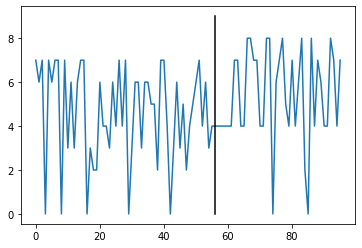

In [102]:
plt.plot([c.depth for c in akf.best_circuit_list])
plt.plot((56, 56), (0, 9), c='black')

In [103]:
## if we just allowed all the GST circuits from the start

# Windowing germ length

In [18]:
num_updates_per_max_germlength = 30

In [81]:
prior_covar = max_fogi_error_rate**2*np.eye(target_model.num_params)

akf = AdapativeFilter(germ1_model, germ1_covar, 2)
akf.param_history = germ1_parameter_history + akf.param_history
akf.covar_history = germ1_covar_history + akf.covar_history
num_updates = 96-56
for n in tqdm(range(num_updates)):
    circuit_list_idx = n // num_updates_per_max_germlength
    if circuit_list_idx > len(edesign.circuit_lists)-2:
        circuit_list_idx = len(edesign.circuit_lists)-2
    akf.best_sigpoint_update(edesign.circuit_lists[circuit_list_idx+1], mdl_datagen, num_samples=256, eig_cutoff=1e-12)

NameError: name 'germ1_model' is not defined

Text(0, 0.5, 'MSE [log]')

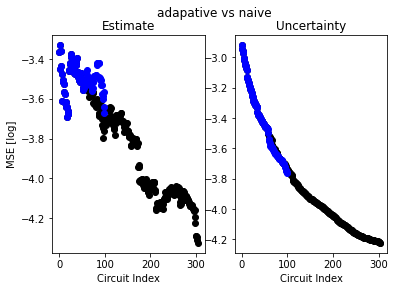

In [115]:
fig, axs = plt.subplots(1, 2)

fig.suptitle('adapative vs naive')
true_params = mdl_datagen.to_vector()

axs[0].set_title('Estimate')
axs[1].set_title('Uncertainty')
plt_spacing = 1

for i in range(0, len(usual_parameter_history), plt_spacing):
    params = usual_parameter_history[i]
    error = np.log10((params-true_params)@(params-true_params))
    axs[0].scatter(i, error, c='black')
    axs[1].scatter(i, np.log10((np.trace(usual_covar_history[i]))), c='black')
    
for i in range(0, len(akf.param_history), plt_spacing):
    params = akf.param_history[i]
    error = np.log10((params-true_params)@(params-true_params))
    axs[0].scatter(i, error, c='blue')
    axs[1].scatter(i, np.log10((np.trace(akf.covar_history[i]))), c='blue')



axs[0].set_xlabel('Circuit Index')
axs[1].set_xlabel('Circuit Index')
axs[0].set_ylabel('MSE [log]')

In [60]:
prior_covar = max_fogi_error_rate**2*np.eye(target_model.num_params)

akf = AdapativeFilter(target_model, prior_covar, 2)
num_updates = 200
for n in tqdm(range(num_updates)):
    circuit_list_idx = n // num_updates_per_max_germlength
    if circuit_list_idx > len(edesign.circuit_lists)-1:
        circuit_list_idx = len(edesign.circuit_lists)-1
    akf.best_sigpoint_update(edesign.circuit_lists[circuit_list_idx], mdl_datagen, num_samples=256, eig_cutoff=1e-12)

  2%|█████                                                                                                                                                                                                   | 5/200 [00:12<07:55,  2.44s/it]


LinAlgError: Singular matrix

Text(0, 0.5, 'MSE [log]')

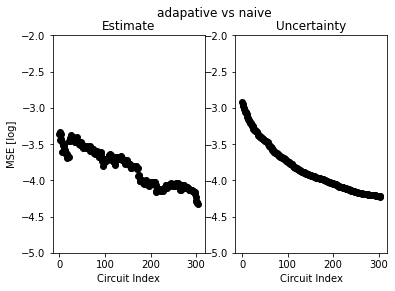

In [61]:
fig, axs = plt.subplots(1, 2)

fig.suptitle('adapative vs naive')
true_params = mdl_datagen.to_vector()
y_range = [-5, -2]

axs[0].set_title('Estimate')
axs[1].set_title('Uncertainty')
plt_spacing = 1

for i in range(0, len(usual_parameter_history), plt_spacing):
    params = usual_parameter_history[i]
    error = np.log10((params-true_params)@(params-true_params))
    axs[0].scatter(i, error, c='black')
    axs[1].scatter(i, np.log10((np.trace(usual_covar_history[i]))), c='black')
    
for i in range(0, len(akf.param_history), plt_spacing):
    params = akf.param_history[i]
    error = np.log10((params-true_params)@(params-true_params))
    axs[0].scatter(i, error, c='blue')
    axs[1].scatter(i, np.log10((np.trace(akf.covar_history[i]))), c='blue')


axs[0].set_ylim(y_range[0], y_range[1])
axs[1].set_ylim(y_range[0], y_range[1])
axs[0].set_xlabel('Circuit Index')
axs[1].set_xlabel('Circuit Index')
axs[0].set_ylabel('MSE [log]')

In [139]:
def adapative_filtering(datagen_model, prior_model, prior_covar, Q, circ_list, num_samples, num_iterations, eig_cutoff=1e-12):
    model = prior_model.copy()
    x_prior = prior_model.to_vector()
    
    param_history = []
    covar_history = []
    
    param_history.append(x_prior)
    covar_history.append(prior_covar)
    
    true_params = datagen_model.to_vector()
    
    for i in range(num_iterations):
        if i > 0:
            x_prior = x_post
            model.from_vector(x_prior)
            prior_covar = post_covar
        # find the best circuit 
        scores = score_circuit_list(prior_covar, circ_list, model, num_samples, Q=Q, eig_cutoff=eig_cutoff)
        best_circ = max(scores, key=scores.get)
        plt.plot(scores.values())
        plt.show()
        
        
        # observe the circuit then do a kalman update with the best circuit
        circ = best_circ
        ds = pygsti.data.simulate_data(datagen_model, [circ], num_samples=256, seed=2021)
        counts = vector_from_outcomes(ds[best_circ].counts, 2**circ.width)
        y_k = counts/sum(counts)
        
        probs = model.probabilities(circ)
        p_model = vector_from_outcomes(probs, 2**circ.width)
        
        jacob = matrix_from_jacob(model.sim.dprobs(circ), 2**circ.width)
        mean_frequency = ( counts+np.ones(len(counts)) )/( sum(counts)+len(counts) )
        R = (1/(sum(counts)+len(counts)+1))*categorical_covar(mean_frequency)

        # Kalman gain
        kgain = prior_covar@jacob.T@np.linalg.pinv(jacob@prior_covar@jacob.T + R, 1e-15)

        # Kalman update
        innovation = y_k - p_model
        x_post = x_prior + kgain@innovation
        post_covar = (np.eye(model.num_params) - kgain@jacob)@prior_covar
        
        param_history.append(x_post)
        covar_history.append(post_covar)
        
    return x_post, post_covar, param_history, covar_history

In [140]:
prior_covar = max_fogi_error_rate**2*np.eye(target_model.num_params)
Q = 0*np.eye(target_model.num_params)
circ_list = edesign.circuit_lists[0]
num_updates = 20
x_post, covar_post, param_history, covar_history = adapative_filtering(mdl_datagen, target_model, prior_covar, Q, circ_list, 256, num_updates, eig_cutoff=1e-12)


KeyboardInterrupt



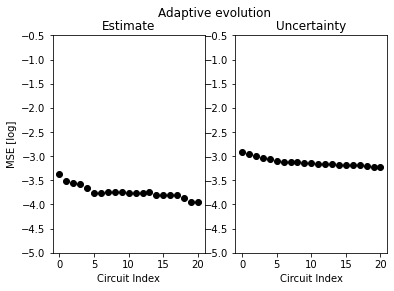

In [43]:
%matplotlib inline
plt_spacing = 1
yrange = [-5, -0.5]
make_error_plot('Adaptive evolution', param_history, mdl_datagen.to_vector(), covar_history, yrange, None, germ_length_ranges, plt_spacing)

In [44]:
circ_list = edesign.circuit_lists[-1]

scores = score_circuit_list(prior_covar, circ_list, target_model, 256, 1e-12)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:15<00:00, 20.04it/s]


Text(0, 0.5, 'MSE [log]')

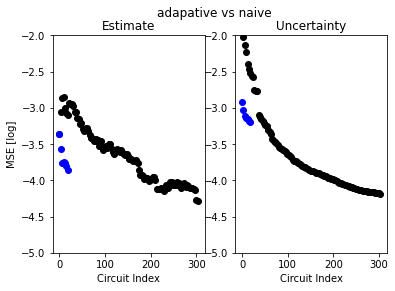

In [44]:
fig, axs = plt.subplots(1, 2)

fig.suptitle('adapative vs naive')
true_params = mdl_datagen.to_vector()
y_range = [-5, -2]

axs[0].set_title('Estimate')
axs[1].set_title('Uncertainty')
plt_spacing = 3

for i in range(0, len(usual_parameter_history), plt_spacing):
    params = usual_parameter_history[i]
    error = np.log10((params-true_params)@(params-true_params))
    axs[0].scatter(i, error, c='black')
    axs[1].scatter(i, np.log10((np.trace(usual_covar_history[i]))), c='black')
    
for i in range(0, len(param_history), plt_spacing):
    params = param_history[i]
    error = np.log10((params-true_params)@(params-true_params))
    axs[0].scatter(i, error, c='blue')
    axs[1].scatter(i, np.log10((np.trace(covar_history[i]))), c='blue')


axs[0].set_ylim(y_range[0], y_range[1])
axs[1].set_ylim(y_range[0], y_range[1])
axs[0].set_xlabel('Circuit Index')
axs[1].set_xlabel('Circuit Index')
axs[0].set_ylabel('MSE [log]')

/usr/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


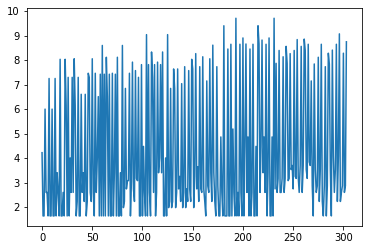

In [45]:
plt.plot(scores.values())